<a href="https://colab.research.google.com/github/Debottam/MachinLearningEx/blob/master/simpleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from numpy import zeros, hstack, ones
from numpy.random import rand, randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

In [0]:
#define standalone discriminator model
def define_discriminator(n_inputs = 2):
  model = Sequential()
  model.add(Dense(25, activation= 'relu', kernel_initializer= 'he_uniform', input_dim = n_inputs))
  model.add(Dense(1, activation='sigmoid'))
  #compile model
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
  return model

#define standalone generator model
def define_generator(latent_dim, n_outputs = 2):
  model = Sequential()
  model.add(Dense(15, activation= 'relu', kernel_initializer= 'he_uniform', input_dim = latent_dim))
  model.add(Dense(n_outputs, activation='linear'))
  #compile model
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
  return model

#define combine generator and discriminator model to train generator alone
def define_gan(generator, discriminator):
  #make weights in discriminator not trainable
  discriminator.trainable = False
  #connect them
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam')
  return model

In [0]:
# generate n real sample with class label
def generate_real_samples(n):
  # generate input in -0.5 and 0.5
  X1 = rand(n)- 0.5
  # generate output X^2
  X2 = X1*X1
  # stack arrays
  X1 = X1.reshape(n,1)
  X2 = X2.reshape(n,1)
  X = hstack((X1,X2))
  # generate class label
  y = ones((n, 1))
  return X,y

# generate latent space as input to generator
def generate_latent_points(latent_dim, n):
  # generate points in the latent space
  x_input = randn(latent_dim*n)
  x_input = x_input.reshape(n,latent_dim)
  return x_input

# use generator to generate fake example
def generate_fake_samples(generator, latent_dim, n):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n)
  # predict output
  X = generator.predict(x_input)
  # generate class label
  y = zeros((n, 1))
  return X,y

In [0]:
# Evaluate the discriminator an plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
  # prepare real sample
  x_real, y_real = generate_real_samples(n)
  # evaluate discriminator on real sample
  _, acc_real = discriminator.evaluate(x_real, y_real,verbose =0)
  # prepare fake sample
  x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
  # evaluate discriminator on fake sample
  _, acc_fake = discriminator.evaluate(x_fake, y_fake,verbose =0)
  print(epoch, acc_real, acc_fake)
  # scatter plot real and fake data points
  pyplot.scatter(x_real[:,0], x_real[:,1], color = 'red')
  pyplot.scatter(x_fake[:,0], x_fake[:,1], color = 'blue')

# Train the generator and discriminator
def train (g_model, d_model, gan_model, latent_dim, n_epochs= 10000, n_batch= 128, n_eval= 2000):
  # half batch for updating the discriminator
  half_batch = int(n_batch/2)
  for i in range(n_epochs):
    # prepare real sample
    x_real, y_real = generate_real_samples(n_batch)
    # prepare fake sample
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
    # update discriminator
    d_model.train_on_batch(x_real, y_real)
    d_model.train_on_batch(x_fake, y_fake)
    # prepare point for the latent space as input to generator
    x_gan = generate_latent_points(latent_dim, n_batch)
    # create inverted labels for the fake samples
    y_gan = ones((n_batch, 1))
    # update generator via discriminator's error
    gan_model.train_on_batch(x_gan, y_gan)
    # evaluate the model in every n_eval epoch
    if (i+1)%n_eval == 0:
      summarize_performance(i, g_model, d_model, latent_dim, n=100)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1999 0.37 0.99
3999 0.3 1.0
5999 0.36 0.77
7999 0.5 0.43
9999 0.37 0.82


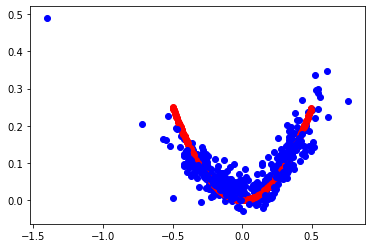

In [27]:
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the discriminator
generator = define_generator(latent_dim)
# create a GAN
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)
